In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from deap import base, creator, tools, algorithms
from optimize_portfolio import optimize_portfolio


In [2]:
"""
Data Setup
"""

# Load the dataset
asset_index = pd.read_excel("data/asset_index.xlsx")
trade_dt = pd.read_excel("data/ashare_trading_calender.xlsx")
asset_index = asset_index[asset_index['TRADE_DT'].isin(trade_dt['TRADE_DT'])]

unique_assets = asset_index['INDEX_CODE'].unique() # index_code list

In [3]:
"""
Clustering (Optional)
"""


'\nClustering (Optional)\n'

In [4]:
"""
GA Initialization
"""

# Objective Setup
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, -1.0)) # MAX: return, sharpe; MIN: volatility (Equally-weighed)
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Individual Initialization (Clustering?)
def create_individual():
    individual = [random.randint(0, 1) for _ in range(len(unique_assets))]
    if sum(individual) == 0:  # If all zeros, randomly set one to 1
        individual[random.randint(0, len(unique_assets) - 1)] = 1
    return individual

# GA Initialization
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(unique_assets))
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [5]:
"""
Fitness Function with Regularization (Optional, prevent overfitting)
"""

# Fitness Function
def evaluate(individual):
    # Select assets based on the individual's binary vector
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]

    # if selected assets are empty (might be caused by mutation, crossover), just set output to extreme situation?
    if len(selected_assets) == 0:
        return 0, 0, 99999 # min return/sharpe, max volatility

    # Model output (new weights)
    new_weights, evaluation = optimize_portfolio('MVO', selected_assets, asset_index)

    # Expected Return, Sharpe Ratio, Volatility (Add regularization parameters? a+b+c=1?)
    expected_return, sharpe_ratio, volatility = evaluation

    return expected_return, sharpe_ratio, volatility

In [6]:
"""
Genetic Algorithm Setup
"""

# NSGA-II
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

In [7]:
""""
Run Genetic Algorithm
"""

# Running the GA
def run_ga(pop_size, num_generations):
    pop = toolbox.population(n=pop_size)
    hof = tools.ParetoFront()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof, verbose=True)

    return pop, hof, stats, logbook

# Example run
population, pareto_front, stats, logbook = run_ga(50, 100)  # X individuals, Y generations

gen	nevals	avg                                           	std                                           	min                                              	max                                           
0  	50    	[1.22307396e-01 3.92975698e-04 8.02141364e+02]	[7.81645400e-02 1.02240463e-03 5.90605084e+02]	[ 1.70346625e-02 -4.06500482e-05  4.08993788e+00]	[2.01615254e-01 5.48971511e-03 2.34944731e+03]
1  	36    	[1.21760119e-01 3.86656124e-04 2.79775988e+03]	[7.89666392e-02 9.94141847e-04 1.38980497e+04]	[ 0.00000000e+00 -4.06500482e-05  7.92758615e+00]	[2.01615254e-01 5.20013491e-03 9.99990000e+04]
2  	35    	[1.18861753e-01 6.40469393e-04 8.06691567e+02]	[7.85990582e-02 2.03003957e-03 6.37554227e+02]	[ 1.70346625e-02 -4.06500482e-05  2.82493371e-01]	[2.01615254e-01 1.30292262e-02 2.34944731e+03]
3  	39    	[1.19502201e-01 3.79890655e-04 8.65370542e+02]	[7.79561528e-02 9.95856690e-04 6.62968107e+02]	[ 1.70346625e-02 -4.06500482e-05  7.92758615e+00]	[2.01615254e-01 5.20013491e-03 2.3494

In [11]:
"""
Pareto Front
"""

# Retrieve Weights/evaluations
def get_weights_evaluations(individual):
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]
    new_weights, evaluation = optimize_portfolio('MVO', selected_assets, asset_index)
    return new_weights, evaluation

# Retrieve and store weights/evaluations
individual_weights = {str(ind): get_weights_evaluations(ind)[0] for ind in pareto_front}
individual_evaluations = {str(ind): get_weights_evaluations(ind)[1] for ind in pareto_front}

# Output
for i, ind in enumerate(pareto_front):
    print(f"Pareto Front {i}")
    print(f"Individual: {ind}")
    print(f"Weights: {individual_weights[str(ind)]}")
    print(f"Evaluations: {individual_evaluations[str(ind)]}")
    print("")

Pareto Front 0
Individual: [0, 0, 0, 1, 0]
Weights: [0.99999998]
Evaluations: (0.20161525394704422, 0.0003007626459446082, 603.8491029251436)

Pareto Front 1
Individual: [0, 0, 0, 1, 0]
Weights: [0.99999998]
Evaluations: (0.20161525394704422, 0.0003007626459446082, 603.8491029251436)

Pareto Front 2
Individual: [0, 0, 0, 1, 0]
Weights: [0.99999998]
Evaluations: (0.20161525394704422, 0.0003007626459446082, 603.8491029251436)

Pareto Front 3
Individual: [1, 1, 1, 1, 0]
Weights: [-4.01274040e-24  9.07782083e-03 -2.81253194e-24  9.90922179e-01]
Evaluations: (0.2, 0.0003008186341782912, 598.3671872312152)

Pareto Front 4
Individual: [0, 1, 1, 1, 0]
Weights: [ 9.07782083e-03 -2.27270637e-25  9.90922179e-01]
Evaluations: (0.2, 0.0003008186341782912, 598.3671872312152)

Pareto Front 5
Individual: [1, 1, 0, 1, 0]
Weights: [-2.81012907e-24  9.07782083e-03  9.90922179e-01]
Evaluations: (0.2, 0.0003008186341782912, 598.3671872312152)

Pareto Front 6
Individual: [0, 1, 0, 1, 0]
Weights: [0.00907782

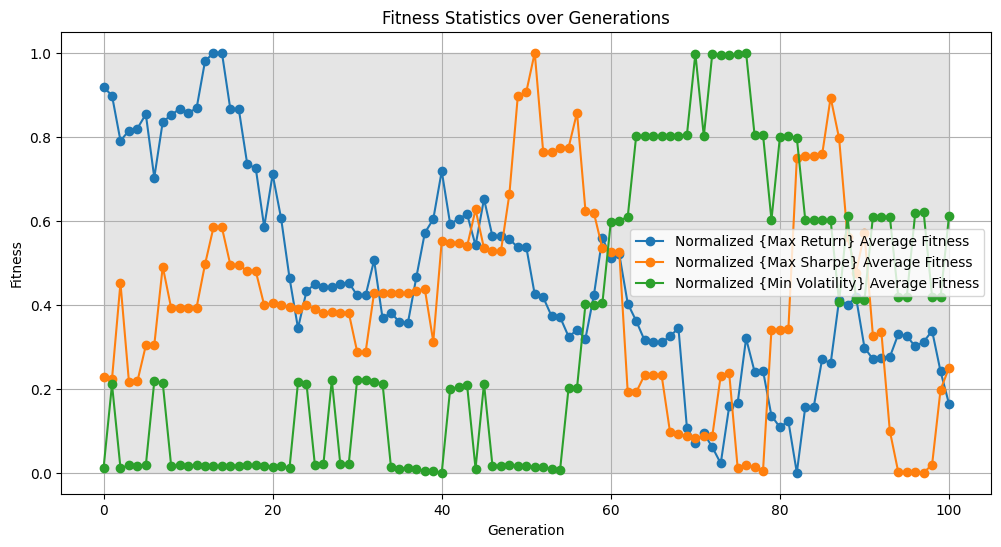

In [9]:
"""
Visualization
"""

# Extracting the statistics
gen = logbook.select("gen")
avg_fitness = logbook.select("avg")
std_fitness = logbook.select("std")
min_fitness = logbook.select("min")
max_fitness = logbook.select("max")

# Normalization function
def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Normalizing the average fitness for each objective
normalized_avg_fitness = [normalize([fit[i] for fit in avg_fitness]) for i in range(len(avg_fitness[0]))]

# Plotting for multiple objectives
plt.figure(figsize=(12, 6))

# Each objective (Avg)
plt.plot(gen, normalized_avg_fitness[0], label=f'Normalized {{Max Return}} Average Fitness', marker='o')
plt.plot(gen, normalized_avg_fitness[1], label=f'Normalized {{Max Sharpe}} Average Fitness', marker='o')
plt.plot(gen, normalized_avg_fitness[2], label=f'Normalized {{Min Volatility}} Average Fitness', marker='o')

# Misc
plt.fill_between(gen, 0, 1, alpha=0.2, color='grey')
plt.title('Fitness Statistics over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()
